In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')



In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes


In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



In [5]:
# Import the mnist data from Keras
from tensorflow.keras.datasets import mnist
# Get data - it is already split into training and testing sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [6]:
# Check shape
X_train.shape



(60000, 28, 28)

In [7]:
# Reshape data
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

In [8]:
# Confirming new shape
X_train.shape

(60000, 28, 28, 1)

In [9]:
# Viewing the first label in original y_train
y_train[0]

5

In [10]:
# Create One-Hot-Encoded target for Tensorflow
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [11]:
## Building a CNN


In [12]:
# Network Structure

# Step 1: Define our network structure
# Save the input shape (skip the number of images)
input_shape = X_train.shape[1:]
input_shape

# Sequential model
model = Sequential()

from tensorflow.keras import layers
# Using rescaling layer to scale pixel values
scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
model.add(scaling_layer)


In [13]:
scaling_layer

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [15]:
# adding a Convolutional layer with 8 filters and kernel size as 3

# Convolutional layer
model.add(
    Conv2D(
        filters=8,  # How many filters you want to use
        kernel_size=3,  # size of each filter
        input_shape=input_shape,  # What is the shape of your input features (we defined this above)
    )
) 
# Pooling layer
model.add(MaxPooling2D(pool_size=2))  # Size of pooling



In [16]:
input_shape

(28, 28, 1)

In [17]:
# Flattening layer
model.add(Flatten())
# Output layer
model.add(
    Dense(10, activation="softmax")  # How many output possibilities we have
)  # What activation function are you using?



In [18]:
# Check model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
____________________________________________________

In [19]:
# Step 2: Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=["accuracy"])



In [20]:
# Step 3: Fit our model
history = model.fit(X_train, y_train, 
                    validation_split=.2,
                    epochs=10)

Epoch 1/10


2023-10-18 16:41:53.152479: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1500/1500 [==============================] - 4s 2ms/step - loss: 0.3852 - accuracy: 0.8935 - val_loss: 0.2424 - val_accuracy: 0.9317
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.2142 - accuracy: 0.9401 - val_loss: 0.1720 - val_accuracy: 0.9529
Epoch 3/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1558 - accuracy: 0.9558 - val_loss: 0.1339 - val_accuracy: 0.9640
Epoch 4/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1232 - accuracy: 0.9653 - val_loss: 0.1207 - val_accuracy: 0.9672
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1048 - accuracy: 0.9693 - val_loss: 0.1039 - val_accuracy: 0.9715
Epoch 6/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0909 - accuracy: 0.9732 - val_loss: 0.1028 - val_accuracy: 0.9707
Epoch 7/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0828 - accuracy: 0.9745 - val_loss: 0.0914 - val_accuracy: 0.9738
Epo

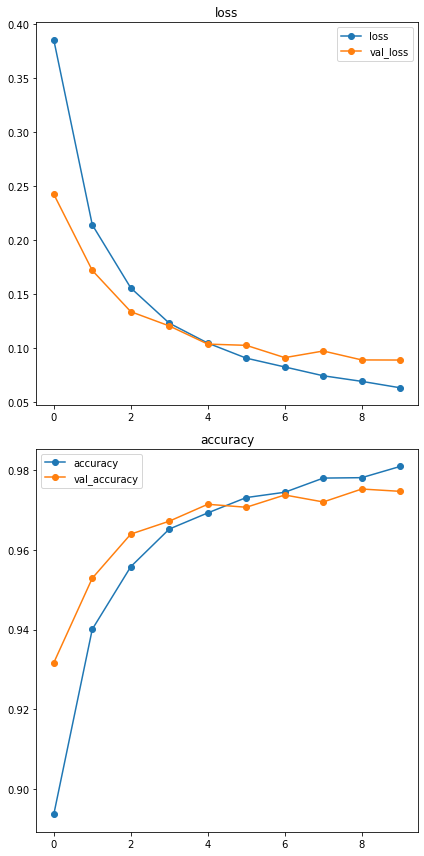

In [21]:
# Call custom function to plot metrics
plot_history(history);



In [22]:
# Evaluate test data with model
model.evaluate(X_test, y_test, return_dict=True)

313/313 [==============================] - 0s 792us/step - loss: 0.0887 - accuracy: 0.9725


{'loss': 0.0887196958065033, 'accuracy': 0.9725000262260437}

In [23]:
# Get predictions for sklearn metrics
y_test_pred = model.predict(X_test)
y_test_pred[0]

313/313 [==============================] - 0s 752us/step


array([2.0573138e-06, 2.8053785e-07, 1.5445070e-06, 1.1690165e-05,
       5.5650360e-09, 1.2082575e-08, 2.0439261e-13, 9.9997818e-01,
       3.3196807e-07, 5.8982423e-06], dtype=float32)

In [24]:
# Sum all the values for the first prediction
sum(y_test_pred[0])

1.0000000050815543

In [25]:
# Find the max value
max(y_test_pred[0])



0.9999782

In [26]:
# Find index at the max value
y_test_pred[0].argmax()



7

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.94      0.96      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.97      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



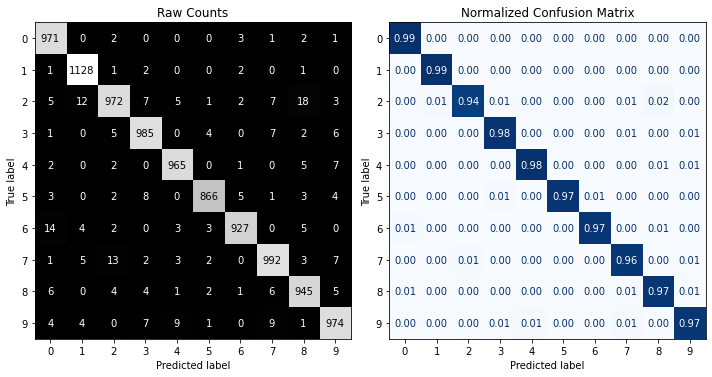

In [27]:
# Getting Sklearn Metrics
classification_metrics(y_test.argmax(axis=1), y_test_pred.argmax(axis=1),
                          label='Test Data',
                         figsize=(10,8))

